IMPORTING ALL NECESSARY LIBRARIES

In [ ]:
!pip install opendatasets

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset
import torchvision
from torchvision import transforms
import pandas as pd
import os
from PIL import Image
import numpy as np
import opendatasets as od
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [ ]:
!pip install kaggle

DOWNLOADING DATASET THROUGH KAGGLE

In [ ]:
# Download dataset from Kaggle
dataset_url = "https://www.kaggle.com/datasets/jessicali9530/celeba-dataset"
od.download(dataset_url)

# Define paths
base_dir = "./celeba-dataset"
img_dir = os.path.join(base_dir, "img_align_celeba/img_align_celeba")
partition_file = os.path.join(base_dir, "list_eval_partition.csv")
attr_file = os.path.join(base_dir, "list_attr_celeba.csv")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: abhaykashyapb22cs001
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset


In [ ]:
partition_df = pd.read_csv('./celeba-dataset/list_eval_partition.csv')
attr_df = pd.read_csv('./celeba-dataset/list_attr_celeba.csv')

partition_map = {0: 'train', 1: 'val', 2: 'test'}
partition_df['partition'] = partition_df['partition'].map(partition_map)

attr_df['young'] = (attr_df['Young'] + 1) // 2
df = pd.merge(partition_df, attr_df[['image_id', 'young']], on='image_id')
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


LOADING DATASET THROUGH **CelebADataset** CLASS

In [ ]:
class CelebADataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.df.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')
        label = torch.tensor(self.df.iloc[idx, 2], dtype=torch.float)
        if self.transform:
            image = self.transform(image)
        return image, label

img_dir = './celeba-dataset/img_align_celeba/img_align_celeba'
train_df = df[df['partition'] == 'train']
val_df = df[df['partition'] == 'val']
test_df = df[df['partition'] == 'test']

train_dataset = CelebADataset(train_df, img_dir, transform)
val_dataset = CelebADataset(val_df, img_dir, transform)
test_dataset = CelebADataset(test_df, img_dir, transform)

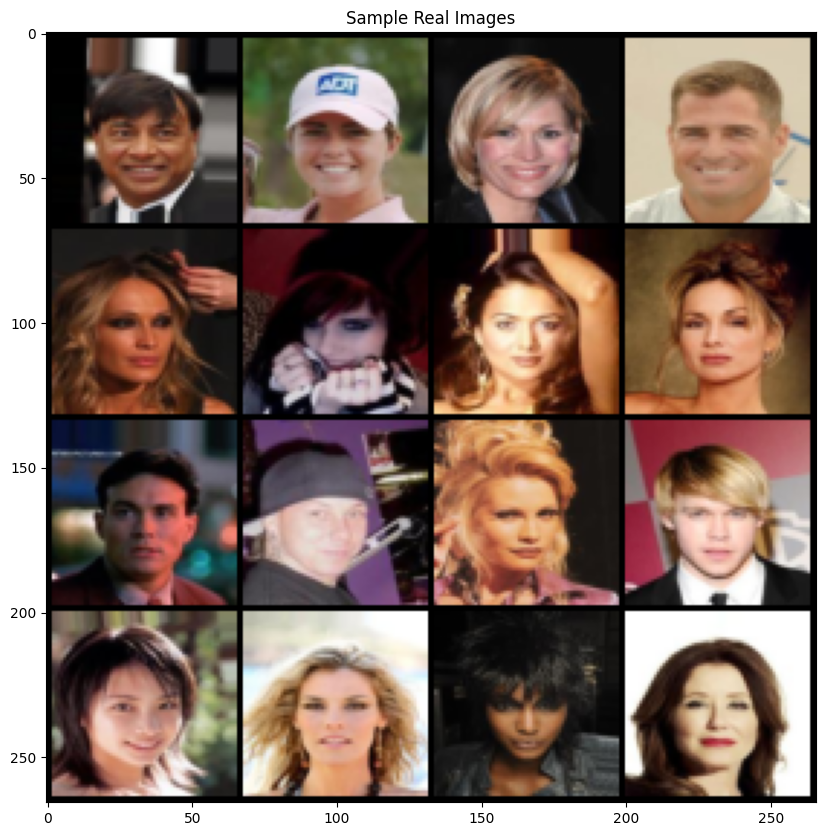

In [ ]:
class CelebAImages(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.df.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

train_images = CelebAImages(train_df, img_dir, transform)
sample_loader = DataLoader(train_images, batch_size=16, shuffle=True)
images = next(iter(sample_loader))
grid = torchvision.utils.make_grid(images, nrow=4, normalize=True)
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0))
plt.title("Sample Real Images")
plt.show()

CREATING DATALOADER AND TRAIN, VAL, TEST

In [ ]:
batch_size = 128
train_loader = DataLoader(train_images, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
train_loader_clf = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

**Generator** and **Discriminator** CLASSES DECLARATION

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim=128, gen_channels=64):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, gen_channels * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(gen_channels * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(gen_channels * 8, gen_channels * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gen_channels * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(gen_channels * 4, gen_channels * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gen_channels * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(gen_channels * 2, gen_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gen_channels),
            nn.ReLU(True),
            nn.ConvTranspose2d(gen_channels, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self, disc_channels=64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, disc_channels, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(disc_channels, disc_channels * 2, 4, 2, 1, bias=False),
            nn.LayerNorm([disc_channels * 2, 16, 16]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(disc_channels * 2, disc_channels * 4, 4, 2, 1, bias=False),
            nn.LayerNorm([disc_channels * 4, 8, 8]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(disc_channels * 4, disc_channels * 8, 4, 2, 1, bias=False),
            nn.LayerNorm([disc_channels * 8, 4, 4]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(disc_channels * 8, 1, 4, 1, 0, bias=False)
        )

    def forward(self, x):
        return self.main(x).view(-1)

CREATING GRADIENT PENALTY

In [ ]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1).to(device)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones(d_interpolates.size()).to(device)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

TRAINING W-GAN

cuda


Epoch 2/3: 100%|██████████| 1272/1272 [09:27<00:00,  2.24batch/s, D_Loss=-6.6255, G_Loss=30.1054]


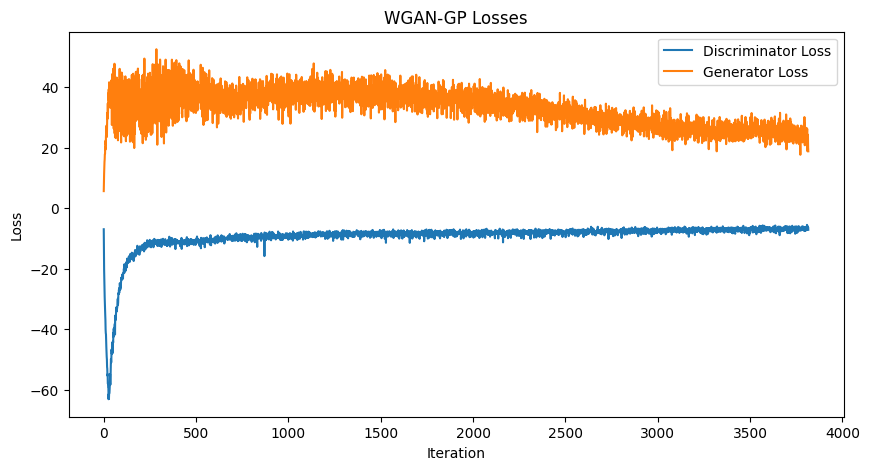

In [ ]:
from tqdm import tqdm

latent_dim = 128
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

lr = 1e-4
optimizer_G = optim.AdamW(generator.parameters(), lr=lr, betas=(0.0, 0.9))
optimizer_D = optim.AdamW(discriminator.parameters(), lr=lr, betas=(0.0, 0.9))

n_critic = 5
lambda_gp = 10
num_epochs = 3

d_losses = []
g_losses = []
print(device)
for epoch in range(num_epochs):
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch}/{num_epochs}", unit="batch") as pbar:
        for i, real_images in enumerate(train_loader):
            real_images = real_images.to(device)
            batch_size = real_images.size(0)

            for _ in range(n_critic):
                optimizer_D.zero_grad()
                z = torch.randn(batch_size, latent_dim, 1, 1).to(device)
                fake_images = generator(z)
                real_validity = discriminator(real_images)
                fake_validity = discriminator(fake_images)
                gp = compute_gradient_penalty(discriminator, real_images, fake_images)
                d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gp
                d_loss.backward()
                optimizer_D.step()

            optimizer_G.zero_grad()
            z = torch.randn(batch_size, latent_dim, 1, 1).to(device)
            fake_images = generator(z)
            g_loss = -torch.mean(discriminator(fake_images))
            g_loss.backward()
            optimizer_G.step()

            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())

            if i % 50 == 0:
                pbar.set_postfix(D_Loss=f"{d_loss.item():.4f}", G_Loss=f"{g_loss.item():.4f}")

            pbar.update(1)

plt.figure(figsize=(10, 5))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.title('WGAN-GP Losses')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()


DISPLAYING THE GENERATED IMAGES

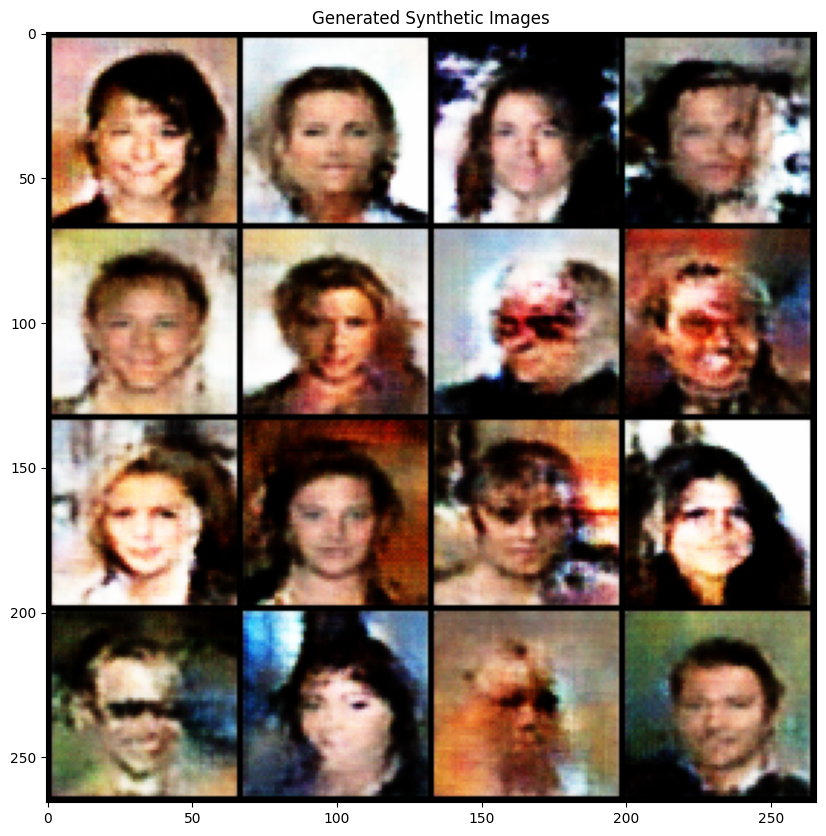

In [ ]:
def generate_images(generator, num_images, latent_dim):
    z = torch.randn(num_images, latent_dim, 1, 1).to(device)
    with torch.no_grad():
        fake_images = generator(z)
    return fake_images
sample_fake = generate_images(generator, 16, latent_dim)

grid = torchvision.utils.make_grid(sample_fake, nrow=4, normalize=True)

plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.title("Generated Synthetic Images")
plt.show()


In [ ]:
!pip install torch-fidelity

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import tempfile
import os
from torch_fidelity import calculate_metrics
from PIL import Image

**Inception Score** and **FID** DISPLAY

In [ ]:
def denormalize(img):
    return ((img * 0.5) + 0.5) * 255
num_images = 500

generator.eval()
with torch.no_grad():
    fake_images = generate_images(generator, num_images, latent_dim)
fake_images = fake_images.cpu().detach()
temp_dir_fake = tempfile.mkdtemp()
temp_dir_real = tempfile.mkdtemp()

for i, img in enumerate(fake_images):
    img = denormalize(img).clamp(0, 255).to(torch.uint8)
    img = img.permute(1, 2, 0).numpy()
    image_pil = Image.fromarray(img)
    image_pil.save(os.path.join(temp_dir_fake, f"fake_{i}.png"))

real_images = []
for imgs, _ in test_loader:
    real_images.append(imgs)
    if len(real_images) * test_loader.batch_size >= num_images:
        break
real_images = torch.cat(real_images, dim=0)[:num_images]
real_images = real_images.cpu().detach()

for i, img in enumerate(real_images):
    img = denormalize(img).clamp(0, 255).to(torch.uint8)
    img = img.permute(1, 2, 0).numpy()
    image_pil = Image.fromarray(img)
    image_pil.save(os.path.join(temp_dir_real, f"real_{i}.png"))

metrics = calculate_metrics(
    input1=temp_dir_fake,
    input2=temp_dir_real,
    cuda=torch.cuda.is_available(),
    isc=True,
    fid=True
)
print("Computed Metrics:", metrics)


Creating feature extractor "inception-v3-compat" with features ['2048', 'logits_unbiased']
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 107MB/s]
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/tmpmv_1kkny" with extensions png,jpg,jpeg
Found 500 samples
/usr/local/lib/python3.11/dist-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloade

Computed Metrics: {'inception_score_mean': 2.8682090065341153, 'inception_score_std': 0.29091453114750054, 'frechet_inception_distance': 175.54448840289712}


Frechet Inception Distance: 175.54448840289712


CNNClassifier CLASS DECLARATION

In [ ]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, 1, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

classifier = CNNClassifier().to(device)
print(device)

cuda


TRAINING THE CLASSIFIER ON "YOUNG" AND "OLD"

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(classifier.parameters(), lr=0.001)

for epoch in range(5):
    classifier.train()
    train_loss = 0
    correct_train = 0
    total_train = 0

    for images, labels in tqdm(train_loader_clf, desc=f"Epoch {epoch+1}/{5} [Training]"):
        images, labels = images.to(device), labels.float().to(device)
        optimizer.zero_grad()
        outputs = classifier(images).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        preds = torch.sigmoid(outputs) > 0.5
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    avg_train_loss = train_loss / len(train_loader_clf)
    train_accuracy = correct_train / total_train * 100
    print(f"Epoch {epoch+1}/{5}, Avg Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%")

    classifier.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{5} [Validation]"):
            images, labels = images.to(device), labels.float().to(device)
            outputs = classifier(images).squeeze()
            val_loss += criterion(outputs, labels).item()

            preds = torch.sigmoid(outputs) > 0.5
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct_val / total_val * 100
    print(f"Epoch {epoch+1}/{5}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")


Epoch 1/5 [Training]: 100%|██████████| 1272/1272 [03:03<00:00,  6.93it/s]


Epoch 1/5, Avg Train Loss: 0.3941, Train Acc: 82.97%


Epoch 1/5 [Validation]: 100%|██████████| 156/156 [00:20<00:00,  7.60it/s]


Epoch 1/5, Val Loss: 0.3939, Val Acc: 83.81%


Epoch 2/5 [Training]: 100%|██████████| 1272/1272 [02:51<00:00,  7.44it/s]


Epoch 2/5, Avg Train Loss: 0.3337, Train Acc: 86.52%


Epoch 2/5 [Validation]: 100%|██████████| 156/156 [00:19<00:00,  8.00it/s]


Epoch 2/5, Val Loss: 0.3637, Val Acc: 85.02%


Epoch 3/5 [Training]: 100%|██████████| 1272/1272 [02:49<00:00,  7.51it/s]


Epoch 3/5, Avg Train Loss: 0.3108, Train Acc: 87.31%


Epoch 3/5 [Validation]: 100%|██████████| 156/156 [00:20<00:00,  7.55it/s]


Epoch 3/5, Val Loss: 0.3801, Val Acc: 84.67%


Epoch 4/5 [Training]: 100%|██████████| 1272/1272 [02:45<00:00,  7.69it/s]


Epoch 4/5, Avg Train Loss: 0.2930, Train Acc: 88.04%


Epoch 4/5 [Validation]: 100%|██████████| 156/156 [00:19<00:00,  8.05it/s]


Epoch 4/5, Val Loss: 0.3418, Val Acc: 85.04%


Epoch 5/5 [Training]: 100%|██████████| 1272/1272 [02:53<00:00,  7.35it/s]


Epoch 5/5, Avg Train Loss: 0.2802, Train Acc: 88.51%


Epoch 5/5 [Validation]: 100%|██████████| 156/156 [00:20<00:00,  7.77it/s]

Epoch 5/5, Val Loss: 0.3308, Val Acc: 86.11%


In [ ]:
import torch
torch.cuda.empty_cache()


GENERATING SYNTHETIC DATASET OF 7% OF ACTUAL (70% CRASHES CUDA)

In [ ]:


num_synthetic = int(0.07 * len(train_dataset))
print(f"Generating {num_synthetic} synthetic samples...")
synthetic_images = generate_images(generator, num_synthetic, latent_dim)

classifier.eval()
synthetic_annotations = []

with torch.no_grad():
    for i in range(0, num_synthetic, batch_size):
        batch = synthetic_images[i:i+batch_size].to(device)
        outputs = classifier(batch).squeeze()
        preds = (torch.sigmoid(outputs) > 0.5).int()
        synthetic_annotations.append(preds.cpu())

synthetic_annotations = torch.cat(synthetic_annotations, dim=0)
synthetic_annotations = synthetic_annotations.float()
print("Annotation complete.")



Generating 11393 synthetic samples...
Annotation complete.


MERGING IT TO REAL DATASET 3% OF ACTUAL, MAINTAINING RATIO OF ACTUAL WITH SYNTHETIC

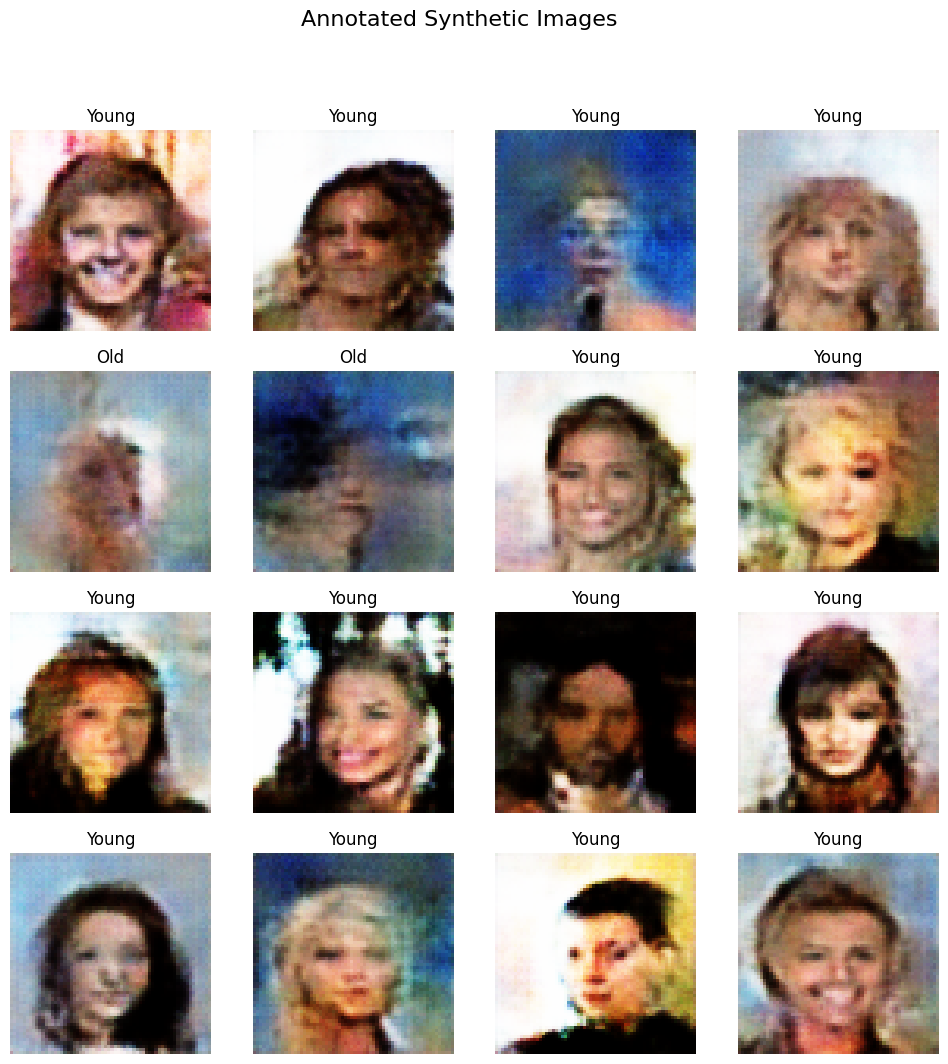

In [ ]:
sample_indices = torch.randperm(num_synthetic)[:16]
sample_imgs = synthetic_images[sample_indices]
sample_labels = synthetic_annotations[sample_indices]

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for ax, idx in zip(axes.flatten(), sample_indices):
    img = denormalize(synthetic_images[idx]).cpu()
    img = img.permute(1, 2, 0).numpy().astype(np.uint8)
    ax.imshow(img)
    label = synthetic_annotations[idx].item()
    ax.set_title("Young" if label == 1 else "Old")
    ax.axis("off")
plt.suptitle("Annotated Synthetic Images", fontsize=16)
plt.show()

In [ ]:
from torch.utils.data import TensorDataset


In [ ]:
synthetic_dataset = TensorDataset(synthetic_images.cpu(), synthetic_annotations)
real_subset_size = int(0.03 * len(train_dataset))
indices = np.random.choice(len(train_dataset), real_subset_size, replace=False)
real_subset = Subset(train_dataset, indices)


CONCATING THE DATASET MERGING BOTH REAL AND SYNTHETIC

In [ ]:
combined_dataset = ConcatDataset([synthetic_dataset, real_subset])
print(f"Combined dataset size: {len(combined_dataset)} samples "
      f"(Synthetic: {len(synthetic_dataset)}, Real: {len(real_subset)})")

combined_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

combined_classifier = CNNClassifier().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(combined_classifier.parameters(), lr=0.001)


Combined dataset size: 16276 samples (Synthetic: 11393, Real: 4883)


TRAINING THE CLASSIFIER ON THE MIXED DATASET

In [ ]:

num_epochs_combined = 5
print("Training classifier on combined synthetic + real data...")
for epoch in range(num_epochs_combined):
    combined_classifier.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(combined_loader, desc=f"Epoch {epoch+1}/{num_epochs_combined}"):
        images = images.to(device)
        labels = labels.float().to(device)
        optimizer.zero_grad()
        outputs = combined_classifier(images).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).int()
        correct += (preds == labels.int()).sum().item()
        total += labels.size(0)
    avg_loss = running_loss / len(combined_loader)
    accuracy_train = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs_combined}, Loss: {avg_loss:.4f}, Training Accuracy: {accuracy_train:.2f}%")



Training classifier on combined synthetic + real data...


Epoch 1/5: 100%|██████████| 199/199 [00:08<00:00, 24.83it/s]


Epoch 1/5, Loss: 0.4317, Training Accuracy: 81.88%


Epoch 2/5: 100%|██████████| 199/199 [00:07<00:00, 26.96it/s]


Epoch 2/5, Loss: 0.3754, Training Accuracy: 84.22%


Epoch 3/5: 100%|██████████| 199/199 [00:07<00:00, 26.41it/s]


Epoch 3/5, Loss: 0.3481, Training Accuracy: 85.40%


Epoch 4/5: 100%|██████████| 199/199 [00:06<00:00, 29.19it/s]


Epoch 4/5, Loss: 0.3230, Training Accuracy: 86.61%


Epoch 5/5: 100%|██████████| 199/199 [00:07<00:00, 25.55it/s]

Epoch 5/5, Loss: 0.3053, Training Accuracy: 87.39%


GETTING ALL THE EVALUATION METRICS

In [ ]:

combined_classifier.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.float().to(device)
        outputs = combined_classifier(images).squeeze()
        preds = (torch.sigmoid(outputs) > 0.5).int()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy_metric = accuracy_score(all_labels, all_preds)
precision_metric = precision_score(all_labels, all_preds)
recall_metric = recall_score(all_labels, all_preds)
f1_metric = f1_score(all_labels, all_preds)

print("\nTest Set Evaluation Metrics:")
print(f"Accuracy : {accuracy_metric:.4f}")
print(f"Precision: {precision_metric:.4f}")
print(f"Recall   : {recall_metric:.4f}")
print(f"F1-score : {f1_metric:.4f}")


Test Set Evaluation Metrics:
Accuracy : 0.8251
Precision: 0.8365
Recall   : 0.9558
F1-score : 0.8922


In [ ]:
!pip install optuna

HYPERPARAMETER TUNING

In [ ]:
import optuna
from tqdm import tqdm
import numpy as np
import os
import tempfile

def objective(trial):

    lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
    batch_size = trial.suggest_categorical('batch_size', [64, 128])
    latent_dim_trial = trial.suggest_categorical('latent_dim', [128, 256])
    n_critic_trial = trial.suggest_int('n_critic', 3, 6)
    lambda_gp_trial = 10
    num_epochs_trial = 3

    subset_size = int(0.1 * len(train_images))
    subset_indices = np.random.choice(len(train_images), subset_size, replace=False)
    from torch.utils.data import Subset
    train_subset = Subset(train_images, subset_indices)
    train_loader_subset = DataLoader(train_subset, batch_size=batch_size, shuffle=True,
                                     num_workers=2, pin_memory=True)

    generator_trial = Generator(latent_dim_trial, ngf=32).to(device)
    discriminator_trial = Discriminator(ndf=32).to(device)

    optimizer_G_trial = optim.AdamW(generator_trial.parameters(), lr=lr, betas=(0.0, 0.9))
    optimizer_D_trial = optim.AdamW(discriminator_trial.parameters(), lr=lr, betas=(0.0, 0.9))

    generator_trial.train()
    discriminator_trial.train()

    final_epoch_g_losses = []

    for epoch in range(num_epochs_trial):
        epoch_g_losses = []
        train_iter = tqdm(train_loader_subset, desc=f"Trial {trial.number} Epoch {epoch+1}/{num_epochs_trial}", leave=False)
        for real_images in train_iter:
            real_images = real_images.to(device)
            current_batch_size = real_images.size(0)

            for _ in range(n_critic_trial):
                optimizer_D_trial.zero_grad()
                z = torch.randn(current_batch_size, latent_dim_trial, 1, 1).to(device)
                fake_images = generator_trial(z)
                real_validity = discriminator_trial(real_images)
                fake_validity = discriminator_trial(fake_images)
                gp = compute_gradient_penalty(discriminator_trial, real_images, fake_images)
                d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp_trial * gp
                d_loss.backward()
                optimizer_D_trial.step()

            optimizer_G_trial.zero_grad()
            z = torch.randn(current_batch_size, latent_dim_trial, 1, 1).to(device)
            fake_images = generator_trial(z)
            g_loss = -torch.mean(discriminator_trial(fake_images))
            g_loss.backward()
            optimizer_G_trial.step()

            epoch_g_losses.append(g_loss.item())
            train_iter.set_postfix({'G_loss': f"{g_loss.item():.4f}"})

        avg_epoch_g_loss = np.mean(epoch_g_losses)
        print(f"Trial {trial.number} Epoch {epoch+1}/{num_epochs_trial} - Avg G_loss: {avg_epoch_g_loss:.4f}")

        if epoch == num_epochs_trial - 1:
            final_epoch_g_losses = epoch_g_losses

    avg_final_g_loss = np.mean(final_epoch_g_losses)
    print(f"Trial {trial.number} Final Avg G_loss: {avg_final_g_loss:.4f}")

    trial.report(avg_final_g_loss, step=num_epochs_trial)
    return avg_final_g_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

print("Best trial:")
print(study.best_trial.params)


[I 2025-03-25 15:20:23,150] A new study created in memory with name: no-name-22b7d0eb-46f6-4c58-9586-cb7e50e26dde
<ipython-input-46-5e068cade6f5>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)


Trial 0 Epoch 1/3 - Avg G_loss: 16.9815


Trial 0 Epoch 2/3 - Avg G_loss: 34.3352


[I 2025-03-25 15:22:47,490] Trial 0 finished with value: 40.77167400717735 and parameters: {'lr': 1.3817636284564913e-05, 'batch_size': 128, 'latent_dim': 128, 'n_critic': 4}. Best is trial 0 with value: 40.77167400717735.


Trial 0 Epoch 3/3 - Avg G_loss: 40.7717
Trial 0 Final Avg G_loss: 40.7717


Trial 1 Epoch 1/3 - Avg G_loss: 25.9016


Trial 1 Epoch 2/3 - Avg G_loss: 17.7885


[I 2025-03-25 15:25:09,815] Trial 1 finished with value: 12.360885358415544 and parameters: {'lr': 0.0009494398075347005, 'batch_size': 128, 'latent_dim': 256, 'n_critic': 4}. Best is trial 1 with value: 12.360885358415544.


Trial 1 Epoch 3/3 - Avg G_loss: 12.3609
Trial 1 Final Avg G_loss: 12.3609


Trial 2 Epoch 1/3 - Avg G_loss: 8.0946


Trial 2 Epoch 2/3 - Avg G_loss: -8.5182


[I 2025-03-25 15:26:53,276] Trial 2 finished with value: -13.337544454312791 and parameters: {'lr': 0.00042673810842252895, 'batch_size': 64, 'latent_dim': 256, 'n_critic': 3}. Best is trial 2 with value: -13.337544454312791.


Trial 2 Epoch 3/3 - Avg G_loss: -13.3375
Trial 2 Final Avg G_loss: -13.3375


Trial 3 Epoch 1/3 - Avg G_loss: 32.7667


Trial 3 Epoch 2/3 - Avg G_loss: 38.2201


[I 2025-03-25 15:28:36,029] Trial 3 finished with value: 32.56185447842467 and parameters: {'lr': 2.96042929559685e-05, 'batch_size': 64, 'latent_dim': 128, 'n_critic': 3}. Best is trial 2 with value: -13.337544454312791.


Trial 3 Epoch 3/3 - Avg G_loss: 32.5619
Trial 3 Final Avg G_loss: 32.5619


Trial 4 Epoch 1/3:  97%|█████████▋| 247/255 [00:53<00:01,  4.63it/s, G_loss=37.7478]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc95c391800>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Trial 4 Epoch 1/3:  97%|█████████▋| 248/255 [00:54<00:01,  4.59it/s, G_loss=42.7654]self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
          Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc95c391800>^
^^Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^^    self._shutdown_workers

Trial 4 Epoch 1/3 - Avg G_loss: 35.0088


Trial 4 Epoch 2/3:  97%|█████████▋| 248/255 [00:52<00:01,  4.66it/s, G_loss=38.3031]Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fc95c391800>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
      self._shutdown_workers() 
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      if w.is_alive(): 
        ^ ^ ^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^


Trial 4 Epoch 2/3 - Avg G_loss: 40.0271


[I 2025-03-25 15:31:19,543] Trial 4 finished with value: 39.24348240272671 and parameters: {'lr': 3.2323602412315244e-05, 'batch_size': 64, 'latent_dim': 256, 'n_critic': 5}. Best is trial 2 with value: -13.337544454312791.


Trial 4 Epoch 3/3 - Avg G_loss: 39.2435
Trial 4 Final Avg G_loss: 39.2435
Best trial:
{'lr': 0.00042673810842252895, 'batch_size': 64, 'latent_dim': 256, 'n_critic': 3}


PRINTING IMAGES GENERATED WITH DEFAULT HYPERPARAMS

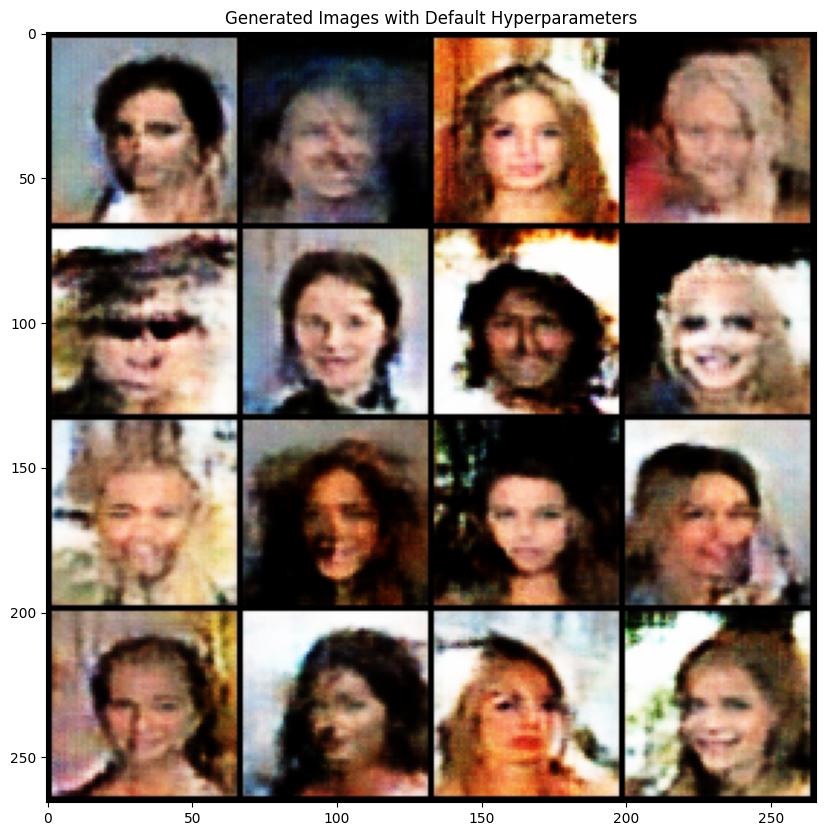

In [ ]:
sample_default = generate_images(generator, 16, latent_dim)
grid_default = torchvision.utils.make_grid(sample_default, nrow=4, normalize=True)
plt.figure(figsize=(10, 10))
plt.imshow(grid_default.permute(1, 2, 0).cpu().numpy())
plt.title("Generated Images with Default Hyperparameters")
plt.show()



In [ ]:
latent_dim = 256
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

lr = 4e-4
optimizer_G = optim.AdamW(generator.parameters(), lr=lr, betas=(0.0, 0.9))
optimizer_D = optim.AdamW(discriminator.parameters(), lr=lr, betas=(0.0, 0.9))

n_critic = 3
lambda_gp = 10
num_epochs = 5

batch_size = 64
train_loader = DataLoader(train_images, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
train_loader_clf = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

cuda


Epoch 2/3: 100%|██████████| 1272/1272 [09:28<00:00,  2.24batch/s, D_Loss=-6.4257, G_Loss=34.5308]


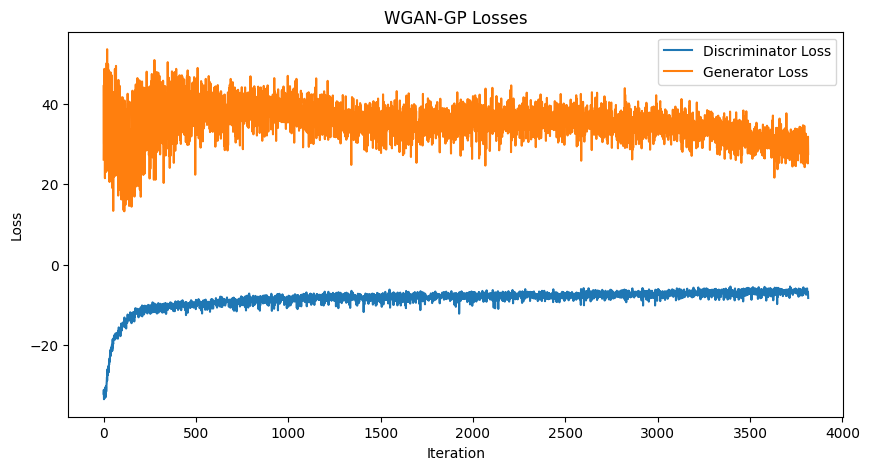

In [ ]:
d_losses = []
g_losses = []
num_epochs = 3
print(device)
for epoch in range(num_epochs):
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch}/{num_epochs}", unit="batch") as pbar:
        for i, real_images in enumerate(train_loader):
            real_images = real_images.to(device)
            batch_size = real_images.size(0)

            for _ in range(n_critic):
                optimizer_D.zero_grad()
                z = torch.randn(batch_size, latent_dim, 1, 1).to(device)
                fake_images = generator(z)
                real_validity = discriminator(real_images)
                fake_validity = discriminator(fake_images)
                gp = compute_gradient_penalty(discriminator, real_images, fake_images)
                d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gp
                d_loss.backward()
                optimizer_D.step()

            optimizer_G.zero_grad()
            z = torch.randn(batch_size, latent_dim, 1, 1).to(device)
            fake_images = generator(z)
            g_loss = -torch.mean(discriminator(fake_images))
            g_loss.backward()
            optimizer_G.step()

            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())

            if i % 50 == 0:
                pbar.set_postfix(D_Loss=f"{d_loss.item():.4f}", G_Loss=f"{g_loss.item():.4f}")

            pbar.update(1)

plt.figure(figsize=(10, 5))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.title('WGAN-GP Losses')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()


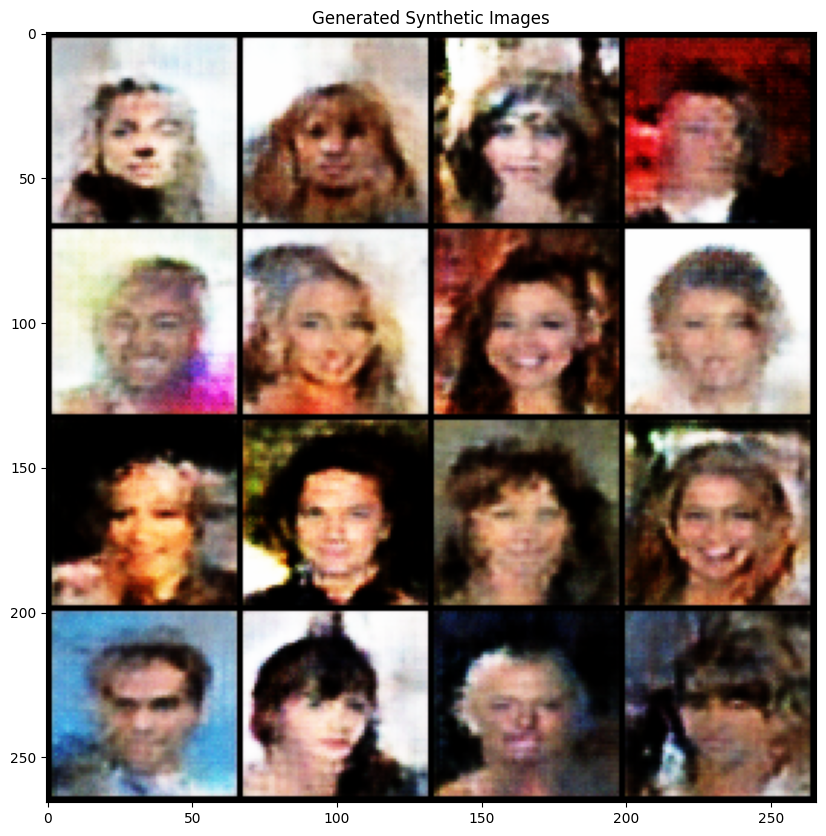

In [ ]:
sample_fake = generate_images(generator, 16, latent_dim)

grid = torchvision.utils.make_grid(sample_fake, nrow=4, normalize=True)

plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.title("Generated Synthetic Images")
plt.show()